In [1]:
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def optimize_inverted_pendulum(A, B, N, T, Q, R, x0):
    X = cp.Variable((A.shape[0], N))  # state
    U = cp.Variable((B.shape[1], N - 1))  # control

    # cost function
    objective = cp.Minimize(
        sum(cp.quad_form(X[:, k], Q) for k in range(N)) +
        sum(R * cp.sum_squares(U[:, k]) for k in range(N - 1)))

    # constraints
    constraints = []
    constraints.append(X[:, 0] == x0)  # Initial state constraint

    for k in range(N - 1):
        constraints.append(X[:, k + 1] == A @ X[:, k] + (dt * B) @ U[:, k])

    # Control input constraints
    # constraints += [X[2, :] >= -np.pi/2, X[2, :] <= np.pi/2]

    # solve
    problem = cp.Problem(objective, constraints)
    problem.solve()
    x_values = X.value
    u_values = U.value

    return x_values, u_values

In [3]:
def compute_robotic_system_matricies_expm(A, B, T):
    M = np.concatenate((A,B), axis = 1)
    l = max(M.shape[0], M.shape[1])
    M.resize(l, l)

    # compute the matrix exponential of M*T
    Md = sp.linalg.expm(M * T)

    # extract A_d and B_d
    A_d = Md[:A.shape[0], :A.shape[1]]
    B_d = Md[:A.shape[0], A.shape[1]:]

    return A_d, B_d

In [108]:
g = 0.0981  # gravity (x 100 m/s^2)
l = 0.18   # pendulum length (x 100 m)
m = 0.21   # pendulum mass (x 10,000 kg)
M = 0.03   # cart mass (x 10,000 kg)
dt = 0.05 # time step (s)
N = 100   # Horizon length (steps)

# State-space matrices
A_0 = np.array([
    [0,   1,  0,                        0],
    [0,   0,  (m * g)/M,                0],
    [0,   0,  0,                        1],
    [0,   0,  (1 * g * (M + m)) / (M * l),  0]
])
B_0 = np.array([
    [0          ],
    [1 / M      ],
    [0          ],
    [1 / (m * l)]
])

Q = np.diag([1, 0.1, 5, 0.1])  # weights position and angle higher
R = 0.01                   # weights control effort very low

# Initial conditions
x0 = np.array([0, 0, 0.15, 0])  # Initial state: small angle deviation

Ad, Bd = compute_robotic_system_matricies_expm(A_0, B_0, dt)

In [109]:
# solve
x_values, u_values = optimize_inverted_pendulum(Ad, Bd, N, dt, Q, R, x0)

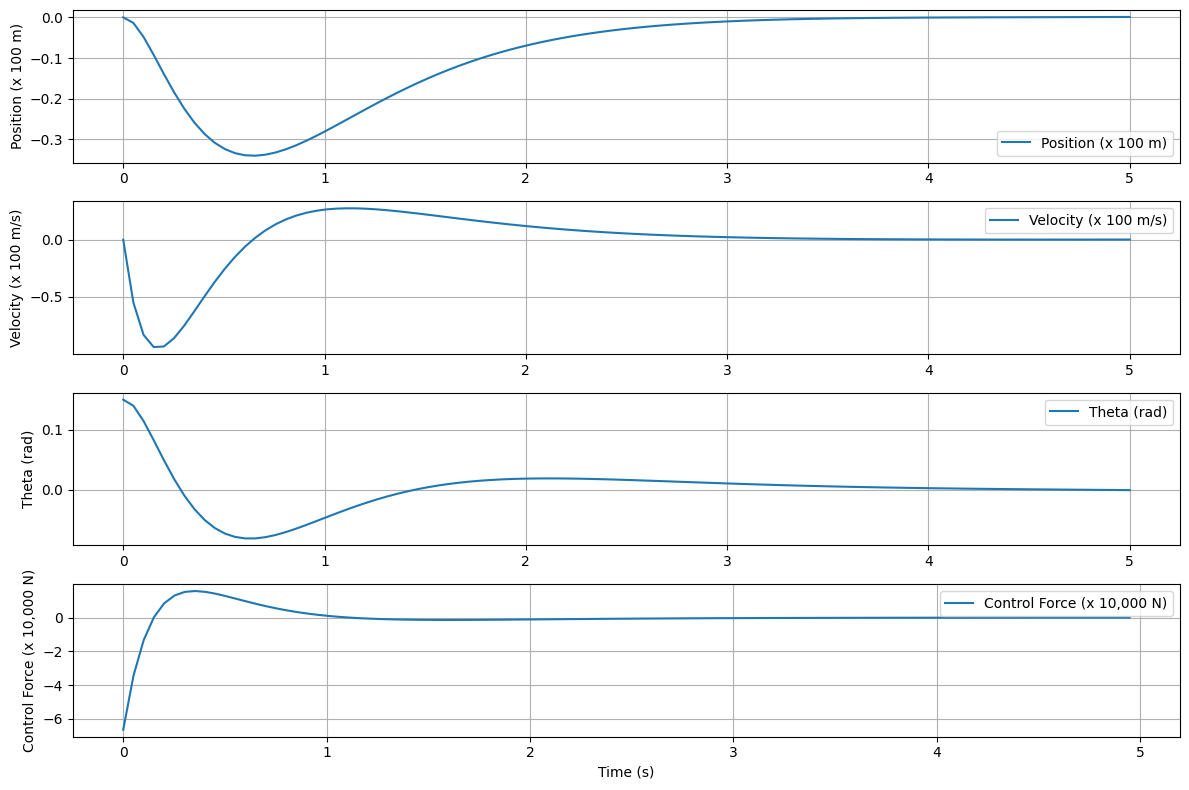

In [110]:
time = np.linspace(0, N * dt, N)

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time, x_values[0, :], label="Position (x 100 m)")
plt.ylabel("Position (x 100 m)")
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(time, x_values[1, :], label="Velocity (x 100 m/s)")
plt.ylabel("Velocity (x 100 m/s)")
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(time, x_values[2, :], label="Theta (rad)")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(time[:-1], u_values[0, :], label="Control Force (x 10,000 N)")
plt.xlabel("Time (s)")
plt.ylabel("Control Force (x 10,000 N)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

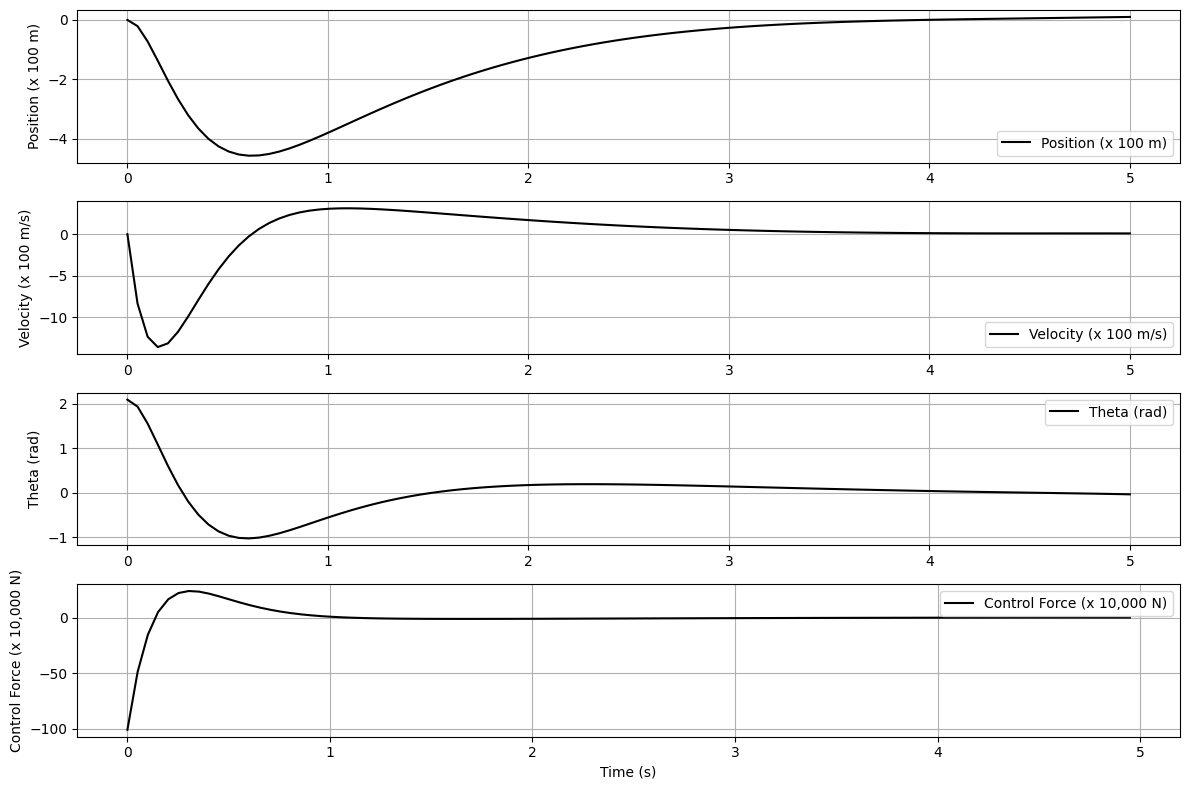

In [107]:
Q = np.diag([1, 0.1, 5, 0.1])  # weights position and angle higher
R = 0.01                   # weights control effort very low

# Initial conditions
x0 = np.array([0, 0, (2/3)*(np.pi), 0])

A, B = compute_robotic_system_matricies_expm(A_0, B_0, dt)

x_values, u_values = optimize_inverted_pendulum(A, B, N, dt, Q, R, x0)

time = np.linspace(0, N * dt, N)

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time, x_values[0, :], label="Position (x 100 m)", color="black")
plt.ylabel("Position (x 100 m)")
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(time, x_values[1, :], label="Velocity (x 100 m/s)", color="black")
plt.ylabel("Velocity (x 100 m/s)")
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(time, x_values[2, :], label="Theta (rad)", color="black")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(time[:-1], u_values[0, :], label="Control Force (x 10,000 N)", color="black")
plt.xlabel("Time (s)")
plt.ylabel("Control Force (x 10,000 N)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()